# Anomaly Detection - Zelong
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>

<br>

**Dennis Milechin, Ivan Sunyagin, Hany Bassily**

Import libraries

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

#import pydotplus
#from IPython.display import Image
#import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("paper")
#sns.set_palette("RdBu", n_colors=32)
#from inspect import getmembers

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as colors

from scipy import stats
from scipy.stats import gaussian_kde as PDF
from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing
#from sklearn.model_selection import cross_val_score as KFcv
#from sklearn.model_selection import KFold
#from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.svm import SVC
#from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier as BaseLine
from sklearn.decomposition import PCA
from sklearn.utils import resample

import StringIO
import collections
from matplotlib import rcParams
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

**---**

## Open a dataset



In [2]:
# Open data set as a sample:
# --------------------------

# Data dictionary
data_dic = {}

# specify date columns
date_range = [[0,1,2,3,4]]

# Open the data files
for i in range(5):
    file_name = 'datasets_h/data_' + str(i+1) + '.txt'
    inter = pd.read_csv(file_name , delim_whitespace = True , skiprows = [1],
                                              parse_dates = date_range , infer_datetime_format = True)
    data_dic['df_' + str(i + 1)] = inter.iloc[:,1:]

# Sanity check    
data_dic['df_1'].head(10)

,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,104,7.9,9.5,99.00,99.00,99.00,999,1012.8,27.9,28.4,26.0,99.0,99.0
1,103,7.6,9.8,99.00,99.00,99.00,999,1013.0,28.2,28.4,26.6,99.0,99.0
2,102,8.9,11.0,99.00,99.00,99.00,999,1013.1,28.2,28.4,26.4,99.0,99.0
3,105,8.5,10.3,99.00,99.00,99.00,999,1013.2,28.3,28.3,26.3,99.0,99.0
4,105,8.6,10.2,1.54,6.67,5.03,89,1013.4,28.2,28.3,25.9,99.0,99.0
5,104,7.7,9.6,99.00,99.00,99.00,999,1013.3,28.3,28.3,26.3,99.0,99.0
6,102,8.2,9.9,99.00,99.00,99.00,999,1013.4,28.3,28.4,26.4,99.0,99.0
7,101,8.8,10.8,99.00,99.00,99.00,999,1013.4,28.3,28.3,26.4,99.0,99.0
8,100,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0
9,101,8.4,10.2,99.00,99.00,99.00,999,1013.8,28.3,28.3,26.5,99.0,99.0


In [3]:
# Concatenate all files:
# ---------------------

# initiation
df_global_raw = data_dic['df_1']

# concatente
for i in range(2,6):
    df_global_raw = pd.concat([df_global_raw , data_dic['df_' + str(i)]] , axis = 0)
    
df_global = df_global_raw[['WDIR' , 'WSPD' , 'GST' , 'PRES' , 'ATMP' , 'DEWP']]

# data array
data_raw = df_global.values

In [4]:
# Preprocessing
# -------------

# determine defected rows
defect = []

# itterrate
for i in range (data_raw.shape[0]):
    if data_raw[i,-1] > 200.:
        defect.append(i)

# remove rows
data = np.delete(data_raw, defect, axis = 0)

# Normalization
data_norm = data / np.std(data, axis = 0)

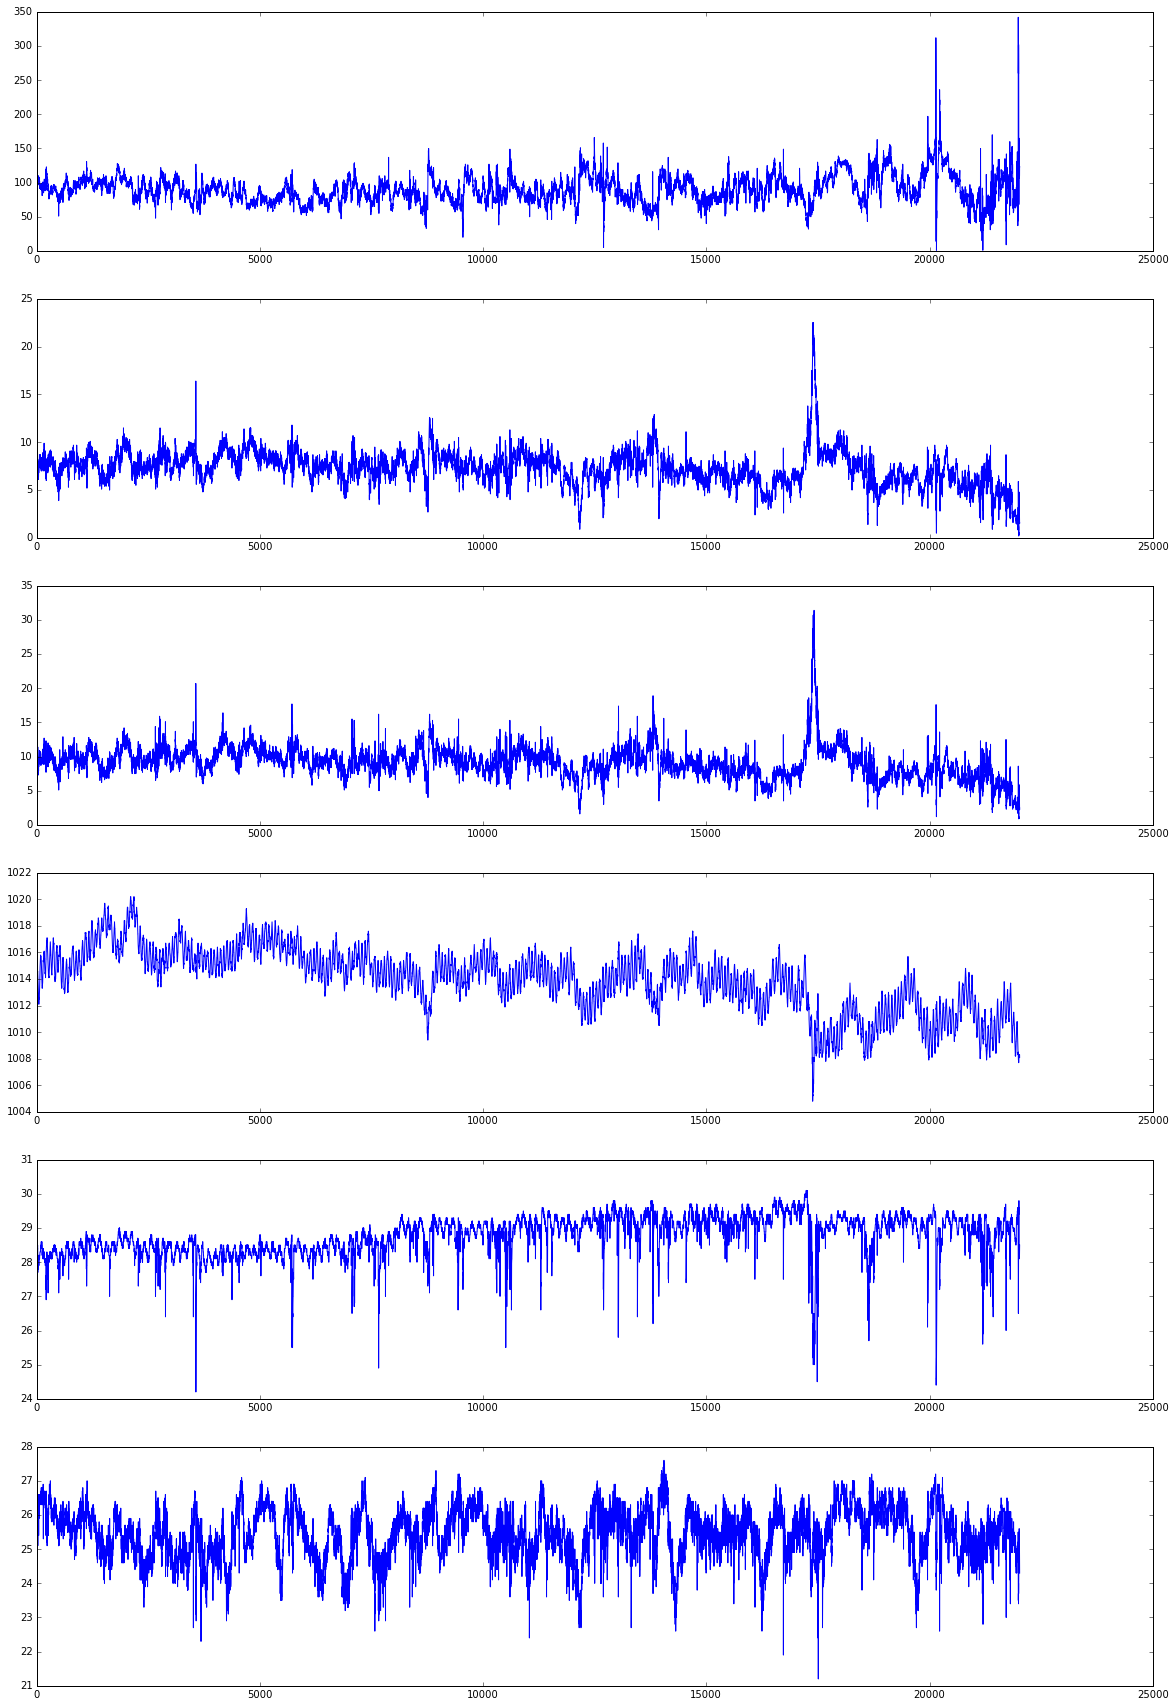

In [5]:
# Visualization
# -------------
fig = plt.figure(figsize = (20, 30))
n = data.shape[1]

# iterrate for data columns
for i in range (n):
    ax = fig.add_subplot(n,1,i + 1)
    ax.plot(data[:,i])
    
plt.show()

In [6]:
# One-step-difference filter application
# --------------------------------------

data_fil = np.zeros(data_norm.shape)

for i in range (1, data_norm.shape[0]):
    data_fil[i, :] = data_norm[i,:] - data_norm[i-1,:]

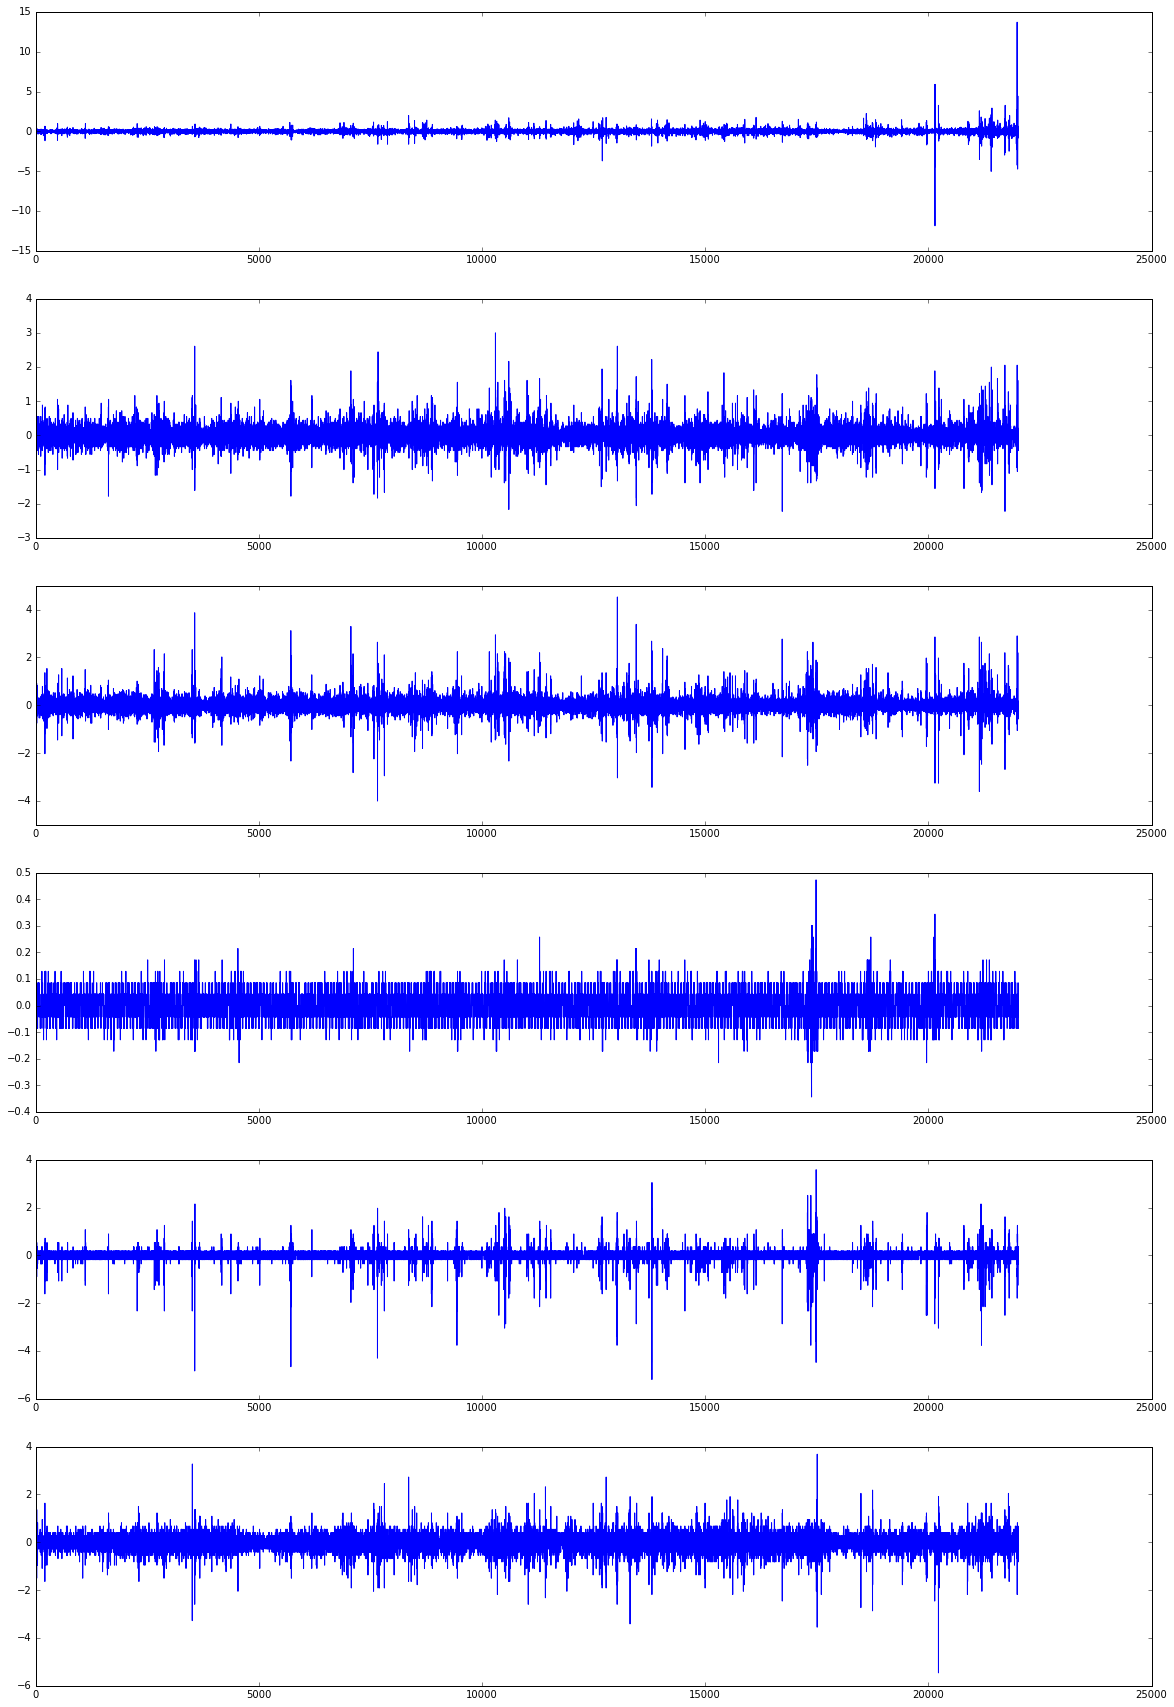

In [7]:
# Visualization
# -------------
fig = plt.figure(figsize = (20, 30))
n = data_fil.shape[1]

# iterrate for data columns
for i in range (n):
    ax = fig.add_subplot(n,1,i + 1)
    ax.plot(data_fil[:,i])
    
plt.show()

In [8]:
# simulated Data
# --------------

d1 = np.random.normal(0. , 0.5 , (3000 , 2))
d2 = np.random.normal(0. , 0.8 , (500 , 2))
d3 = np.random.normal(0. , 0.5 , (3000 , 2))

sim_data1 = np.concatenate((d1, d2) , axis = 0)
sim_data = np.concatenate((sim_data1 , d3), axis = 0)

In [9]:
# Integral function to calculate the mixture Power Martingale:
# ------------------------------------------------------------

def trap_mix(m,e):
    
    # initiate integral
    integral = 0.
    
    # iterrate over all values of epsilon
    for i in range (len(e) - 1):
        
        # trapezoid
        b = 0.5 * (m[i] + m[i + 1])
        h = e[i + 1] - e[i]
        
        # Integral
        integral += b * h
        
    return integral
        

In [20]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale_mix(d , dummy):
    
    # grid resolution for mix integration
    res = 100

    # epsilon array
    eps = np.linspace(0.001, 0.999, res)
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i - 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( np.sum(alpha_sub > end) + np.random.uniform() * np.sum(alpha_sub == end ) ) / n
    
        # to avoid log zero
        p_value[p_value==0] = 1.
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = np.zeros((res,))

    # iterrate for power martingale calculation
    for i in range(L):
    
        # iterrate for each epsilon    
        for j in range (res):
            # M += np.log(eps) + (eps - 1.) * np.log(p_value[i])
            M += np.log(eps) + (eps - 1.) * np.log(p_value[i])
        
        # Array
        power_mart[i] = trap_mix(M , eps)
        
        
    return power_mart , dummy

In [21]:
# Function to calculate Power Martingale:
# ---------------------------------------

def power_martingale(d , eps):
 
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.ones(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i + 1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.000000001
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 0.
    
    # initiate difference measure
    diff_arr = np.zeros((L,))
    
    # Initiate difference multiplier
    diff = 1.

    # iterrate for power martingale calculation
    for i in range(L):
        
        # increment
        delta = eps * (p_value[i]) ** (eps - 1.)
        
        # Calculate martingale difference
        # diff_arr[i] = np.log( np.absolute(diff * (delta - 1.)) )
        diff_arr[i] = np.log(delta)
        
        # update diff
        diff *= delta
        
        # Update power martingal
        M += np.log(delta)  
        
        # Array
        power_mart[i] = M
        
    return power_mart , diff_arr

In [22]:
# Function to calculate Plugin Martingale:
# ---------------------------------------

def plugin_martingale(d):
    
    # data mean
    mean = np.average(d , axis = 0)
    
    # mean vector norm
    mean_norm = np.linalg.norm(mean)

    # strangenes reference
    ref_alpha = np.linalg.norm(d.std(axis = 0)) + mean_norm

    # Length of data
    L = d.shape[0]

    # alpha
    alpha = np.linalg.norm(d , axis = 1) / ref_alpha

    # p-value(randomised)
    p_value = np.zeros(alpha.shape)

    # iterrate for p-value calculation
    for i in range(1,L):
    
        # end value
        end = alpha[i]
    
        # alpha subset
        alpha_sub = alpha[:i+1]

        # number of elements
        n = i + 1   
    
        # p-values calculation
        p_value[i] = ( float(np.sum(alpha_sub > end)) + np.random.uniform() * np.sum(alpha_sub == end ) ) / float(n)
    
        # to avoid log zero
        p_value[p_value==0] = 0.00000001
        
    # Extended sample
    p_value_neg = - p_value
    p_value_ref = 2.0 - p_value
    
    # initiate Power Martingale
    power_mart = np.zeros(alpha.shape)

    # dummy multiplier
    M = 1.

    # iterrate for plugin martingale calculation
    for i in range(1,L):
        
        # samples
        s1 = p_value_neg[:i]
        s2 = p_value[:i]
        s3 = p_value_ref[:i]
        
        # concatenation
        s12 = np.concatenate((s1 , s2) , axis = 0)
        sample = np.concatenate((s12 , s3) , axis  = 0)
        
        # Estimate pdf
        den = PDF(sample, bw_method='silverman')
        
        # Integral
        A = den.integrate_box_1d(0,1)
        
        # Evaluate
        f =  den.evaluate(p_value[i]) / A
        M *= f
        power_mart[i] = M      
    
    # First Element
    power_mart[0] = power_mart[1]
    
    
    return power_mart

In [13]:
# Kalman Filter
# ------------

def kalman(y):
    x = np.zeros(y.shape)
    p = np.zeros(y.shape)
    q = 0.0001
    r = 10.
    L = y.shape[0]
    x[0] = y[0]
    p[0] = 0.01
    for i in range(1,L):
        p[i] = p[i - 1] + q
        k = p[i] / (p[i] + r)
        x[i] = x[i - 1] + k * (y[i] - x[i - 1])
        p[i] = p[i] * ( 1 - k )
        
    return x

In [14]:
# Epsilon Value
# -------------

e = 0.75

In [15]:
# Application and Visualization (Power Martingale)
# -----------------------------------------------

# simulated data 
p_mar1 , diff1 = power_martingale(sim_data,e)

# Raw data
p_mar2, diff2 = power_martingale(data,e)

# normalized data
p_mar3, diff3 = power_martingale(data_norm,e)

# on-step-difference filtered data
p_mar4, diff4 = power_martingale(data_fil,e)

##

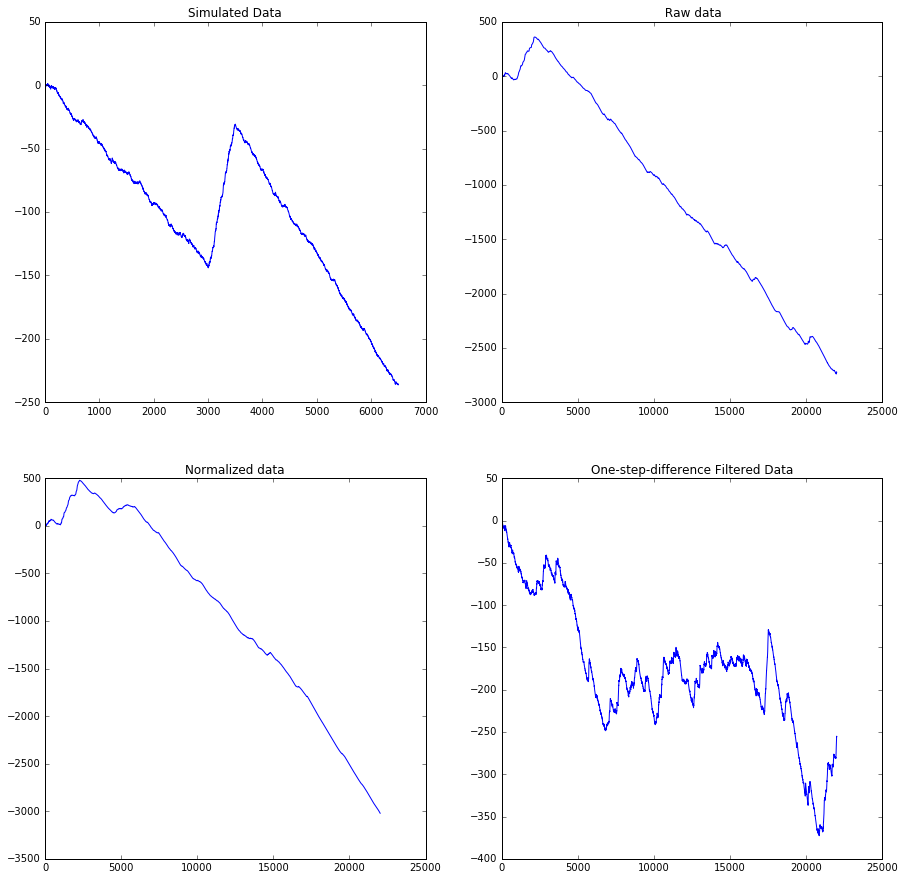

In [16]:
# Visualization of Power Martingale
# ---------------------------------

# plot initialization
fig = plt.figure(figsize = (15,15))

# plot simulated data
ax1 = fig.add_subplot(2,2,1)
ax1.plot(p_mar1)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(2,2,2)
ax2.plot(p_mar2)
ax2.set_title(' Raw data')

# plot normalized data
ax3 = fig.add_subplot(2,2,3)
ax3.plot(p_mar3)
ax3.set_title('Normalized data')

# plot one-step-difference filtered data
ax4 = fig.add_subplot(2,2,4)
ax4.plot(p_mar4)
ax4.set_title('One-step-difference Filtered Data')

plt.show()

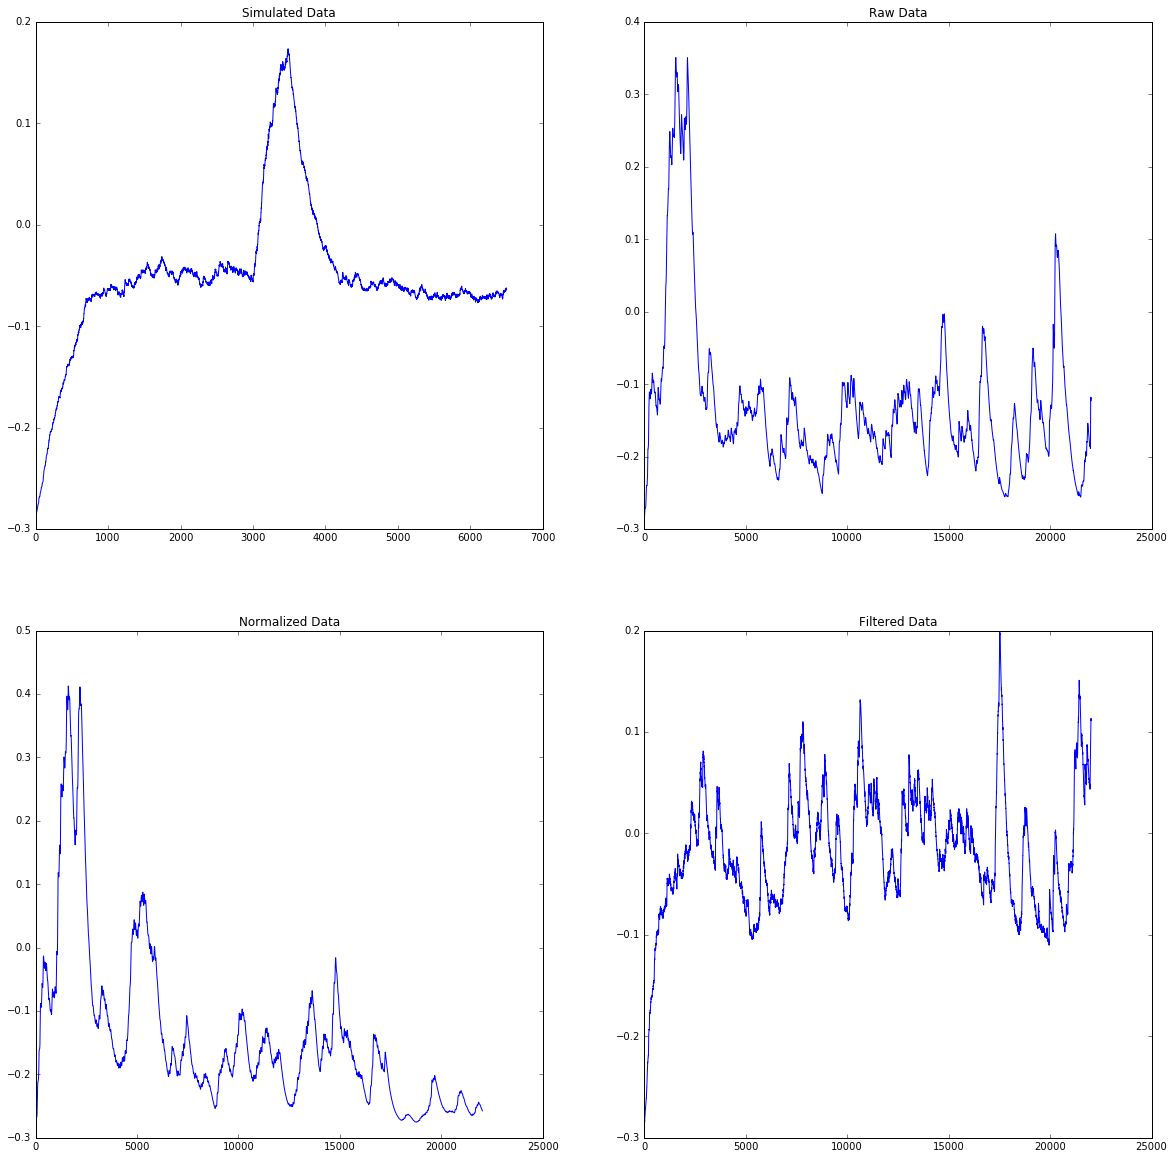

In [17]:
# Visualize change detection
# --------------------------

fig = plt.figure(figsize = (20,20))

# determine length
L = diff1.shape[0]

# specify start and end
a , b = 0 , L

# Simulated Data
ax1 = fig.add_subplot(221)
ax1.plot(kalman(diff1))
ax1.set_title('Simulated Data')

# Raw data
ax2 = fig.add_subplot(222)
ax2.plot(kalman(diff2) )
ax2.set_title('Raw Data')

# Normalized data
ax3 = fig.add_subplot(223)
ax3.plot(kalman(diff3) )
ax3.set_title('Normalized Data')

# Normalized data
ax4 = fig.add_subplot(224)
ax4.plot(kalman(diff4))
ax4.set_title('Filtered Data')

plt.show()

In [18]:
# Application and Visualization (Plugin Martingale)
# -------------------------------------------------

# simulated data 
p_mar1p = plugin_martingale(sim_data)

# Raw data
p_mar2p = plugin_martingale(data)

# normalized data
p_mar3p = plugin_martingale(data_norm)

# on-step-difference filtered data
p_mar4p = plugin_martingale(data_fil)

##

---

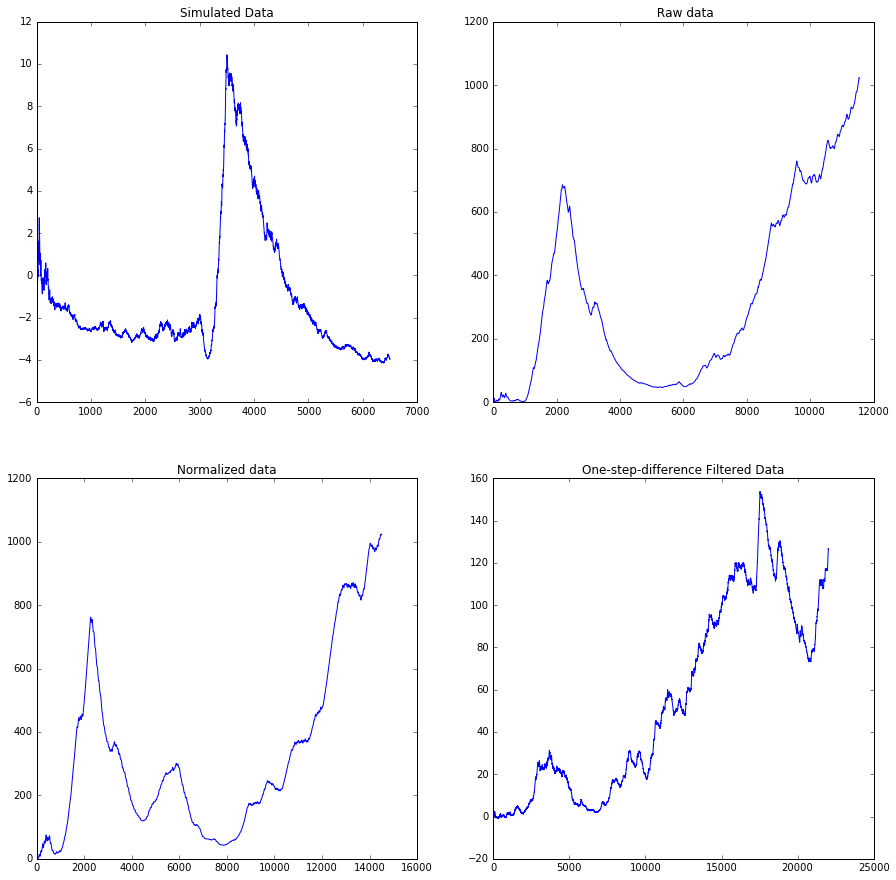

In [29]:
# plot initialization

x1 = np.log2(p_mar1p)
x2 = np.log2(p_mar2p)
x3 = np.log2(p_mar3p)
x4 = np.log2(p_mar4p)

# initialize image
fig = plt.figure(figsize = (15,15))

# plot simulated data
ax1 = fig.add_subplot(2,2,1)
ax1.plot(x1)
ax1.set_title('Simulated Data')

# plot raw data
ax2 = fig.add_subplot(2,2,2)
ax2.plot(x2)
ax2.set_title(' Raw data')

# plot normalized data
ax3 = fig.add_subplot(2,2,3)
ax3.plot(x3)
ax3.set_title('Normalized data')

# plot one-step-difference filtered data
ax4 = fig.add_subplot(2,2,4)
ax4.plot(x4)
ax4.set_title('One-step-difference Filtered Data')

plt.show()

---